# About
A jupyter notebook used to model and evaluate different towed instruments used for sampling the 
submesoscale.

In [1]:
"""Import and setup cell, does not do any logic work. Runs first"""
import os

import libmodeldata
import libinstruments

import numpy
import matplotlib.pyplot as plt
import netCDF4

import cmocean

CMAP = cmocean.cm.dense #"viridis_r" 
CMAP_DIFF = "bwr"

DEBUG = False
SAVEFIGS = False
XLIM = (1000, 3000)
FEATURE_CENTER = 2000
FRONT = True

plt.close("all")
plt.rcParams["font.size"] = 18

print("Modules and constants loaded successfully")

Modules and constants loaded successfully


# Modelling the transect data
A data model is computed based on a measured or simulated density profile. Simplifying assumptions are 
that the vertical density profile is constant over time/distance and perturbations in the 
vertical do not change the profile itself, but move the entire profile up or down. Using a data file
as model profile input is currently not maintained.

Parameters for the models are inspired by two well known publications:
[1] Spall, 1995: Frontogenesis, subduction, and cross-front exchange at upper ocean fronts
[2] Capet et al., 2008: Mesoscale to Submesoscale Transition in the California Current System. Part II: Frontal Processes

In [2]:
"""Model setup cell. After running this cell the model data is in memory"""
figures = {}
# data_filepath = "/home/thomas/0_working_local/tc2013/20110414/Vessel/TIA_20110414_part1.mat"
if FRONT:
    model = libmodeldata.Model_SingleFront(domain_length=4000, max_depth=100, x_step=5,
    base_temp=25, tc_drop=-0.8, tc_start=50, tc_size=15)
    # model.create_var_array_from_profile_file(data_filepath)
    model.create_var_array_from_function()
    model.add_frontal_feature(FEATURE_CENTER, 50, 500)
else:
    model = libmodeldata.Model_InternalWave(domain_length=12000, max_depth=100, x_step=10)
    # model.create_var_array_from_profile_file(data_filepath)
    model.create_var_array_from_linear()
    # model.add_noise_to_var_array()
    model.compute_internal_wave(wave_center = model.DOMAIN_LENGTH/2, wave_height=12)

if DEBUG:
    figures["debug_model_data"] = model.plot_model_data()
    figures["debug_model_profile"] = model.plot_model_profile()

Setting up Model parameters
Model dims are:
dim_x: 800
dim_z: 1000
x_step: 5
z_step: 0.1
Domain length is: 4000
Using modelled linear temperature drop
front starts at idx0=350 -> x0=1750.0
front ends at idx1=450 -> x1=2250.0


# Modelling the instruments
Three types of instruments are set up for the intercomparison of the different sampling
approaches used in the submesoscale as reported in [3]:

1: Horizontally towed CTDs attached to a string (towed CTD chains, for instance [4])  
2: Undulating devices following sawtooth pattern (for instance SeaSoar, [5])  
3: Repeatedly vertical profiling instruments used underway (underway CTD, [6])  


# The towed CTD chain
A towed CTD chain is simulated using a set of parameters used by our own working group during
the M160 cruise on German research vessel Meteor in late 2019 [7]. About 15 CTD+1 sensors 
were used sampling at a rate of about 6-7 Hz. The targeted depth was about 100 m, actual depths was 
between 120 and 90 m. The Meteor steamed at about 6 kn, which is approx. 3 m/s.  

[3] Levy et al. 2012: Bringing physics to life at the submesoscale: FRONTIER  
[4] Sellschopp et al., 1997: A towed CTD chain for two-dimensional high resolution hydrography  
[5] Pollard, 1987: Frontal surveys with a towed profiling conductivity /temperature/depth measurement package (SeaSoar)  
[6] Rudnick and Klinke, 2007: The Underway Conductivity–Temperature–Depth Instrument  
[7] Körtzinger et al. 2020: Eddy Study to Understand Physical-Chemical-Biological Coupling and the Biological Carbon Pump as a Function of Eddy Type off West Africa, Cruise No. M160, 23.11.2019 - 20.12.2019, Mindelo (Cabo Verde) - Mindelo (Cabo Verde)


Simulating a tow chain with
TIA number of sensors: 15
TIA sensor spacing: 7.00 m
TIA sensor depths in m: 2.00, 9.00, 16.00, 23.00, 30.00, 37.00, 44.00, 51.00, 58.00, 65.00, 72.00, 79.00, 86.00, 93.00, 100.00, 
TIA Sampling Rate: 6 1/s
TIA boat speed: 3 m/s


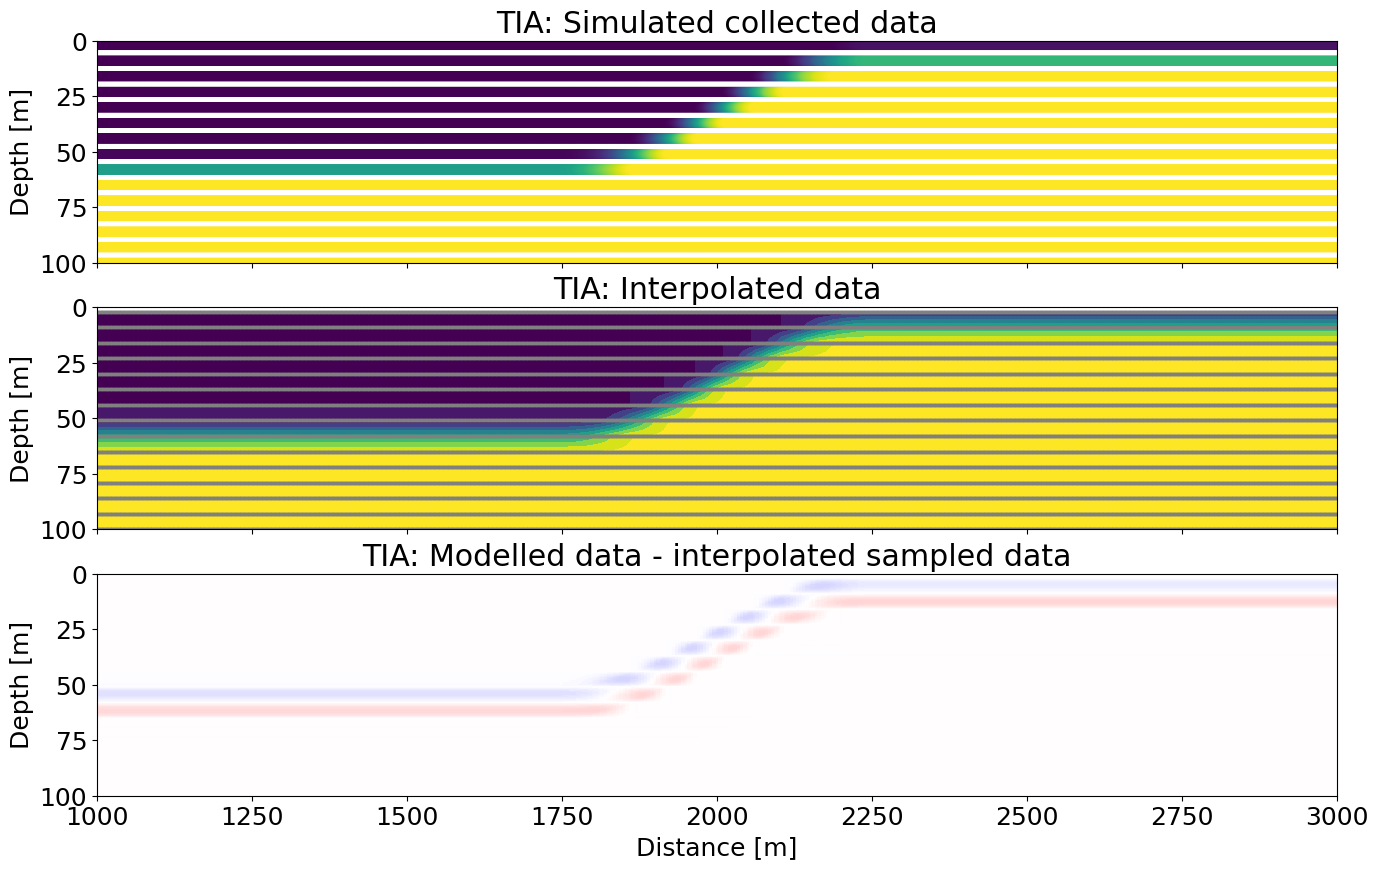

In [3]:
"""Setup Towed Chain instrument and simulate data collection"""
tia = libinstruments.TIA(model, sensor_depths=(2,100,15),sample_rate=6, boat_speed=3, cmap=CMAP)
tia.simulate_data_collection()
tia.interpolate_to_model_grid()
figures["tia"] = tia.plot_data(xlim=XLIM)


with netCDF4.Dataset(f"{os.path.expanduser('~')}/tiasamples.nc", "w") as d:
    d.createDimension("dist", tia.nx)
    d.createDimension("depth", tia.sensor_count)
    d.createVariable("x", "f4", ("dist",))
    d.createVariable("z", "f4", ("depth",))
    d.createVariable("values", "f4", ("dist", "depth"))
    d.variables["values"][:,:] = tia.t_samples.T
    d.variables["x"][:] = tia.x_samples
    d.variables["z"][:] = tia.SENSOR_DEPTHS


# The undulating instrument
As pointed out before the SeaSoar instrument [5], others, serves as a well
established instrument for the group of undulating instruments. The operating parameters are
taken from Pidcock et al. 2010, section 2b. They used the SeaSoar at 8.5 kn (about 4.25 m/s)
vessel speed, a diving rate of 1.3 m/s and a sampling rate of 1 Hz.  
For better comparison we choose a vessel speed of also 3 m/s and a more modern sampling rate of 10 Hz.

In [4]:
"""Setup Undulating instrument and simulate data collection"""
undu = libinstruments.Undulating(model, sample_rate=10, offset=0, 
    min_depth=2, boat_speed=3, dive_rate=1.3, cmap=CMAP)
undu.simulate_data_collection()
undu.interpolate_to_model_grid()
figures["undu"] = undu.plot_data(xlim=XLIM)

if 1:
    with netCDF4.Dataset("/home/thomas/undusamples.nc", "w") as d:
        d.createDimension("nx", undu.nx)
        d.createVariable("x", "f4", ("nx",))
        d.createVariable("z", "f4", ("nx",))
        d.createVariable("values", "f4", ("nx",))
        d.variables["values"][:] = undu.t_samples
        d.variables["x"][:] = undu.x_samples
        d.variables["z"][:] = undu.z_samples


Simulating a undulating device like EIVA Scanfish or SeaSoar
SF Dive Rate: 1.3 m/s
SF Sample Rate: 10 1/s
SF Boat Speed: 3 m/s
Simulate sampling with undulating device ... done
Interpolating undulating device data to model grid ... done
Plotting scanfish data ... done


# The vertical profiling instrument
The underway CTD described in [6] serves as a representative for the group of 
vertically profiling instruments. Operating parameters are taken from this paper, which is also
the default for the modelled instrument. The drop rate is about 4 m/s, the recover rate about 
0.89 m/s. The instruments samples at 10 Hz. No time for tail spooling or instrument handling
is taken into account, meaning the vertical profiles are as close together as possible.

Note: We do not consider the use of XBTs as a contender for this group of instruments because of
their single use nature.


Simulating an underway CTD as described in Rudnick and Klinke 2007
uCTD drop rate: 4 m/s
uCTD Recover Rate: 0.89 m/s
uCTD Sample Rate: 10 1/s
uCTD respool time: 0 s
Simulating UCTD sampling ... done
Interpolating UCTD data to model grid ... done
Plotting UCTD data ... done


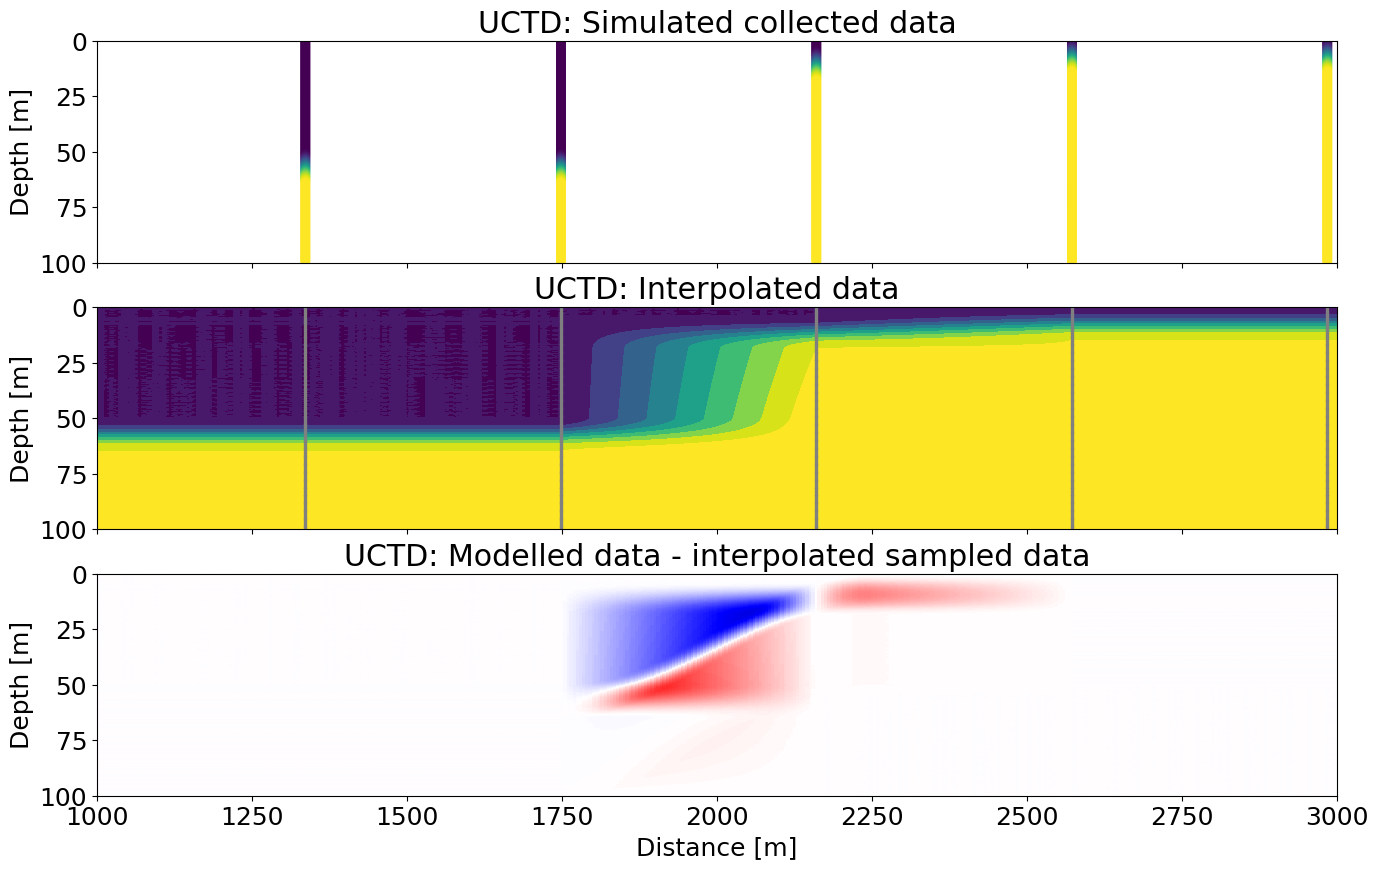

In [5]:
"""Setup and simulate vertical profiling instrument"""
uctd = libinstruments.UCTD(model, cmap=CMAP, boat_speed=3)
uctd.simulate_data_collection()
uctd.interpolate_to_model_grid()
figures["uctd"] = uctd.plot_data(xlim=XLIM)

# Comparison
All three instruments simulate data collection in the same model domain and are subsequently 
linearly interpolated to the original model grid. Thus, we can easily compute local deviations
from modelled to sampled/interpolated data.

Maximum delta for TIA: 0.0853
Maximum delta for Undu: 0.6119
Maximum delta for UCTD: 0.5776
Max error: 0.612, min error: -0.578


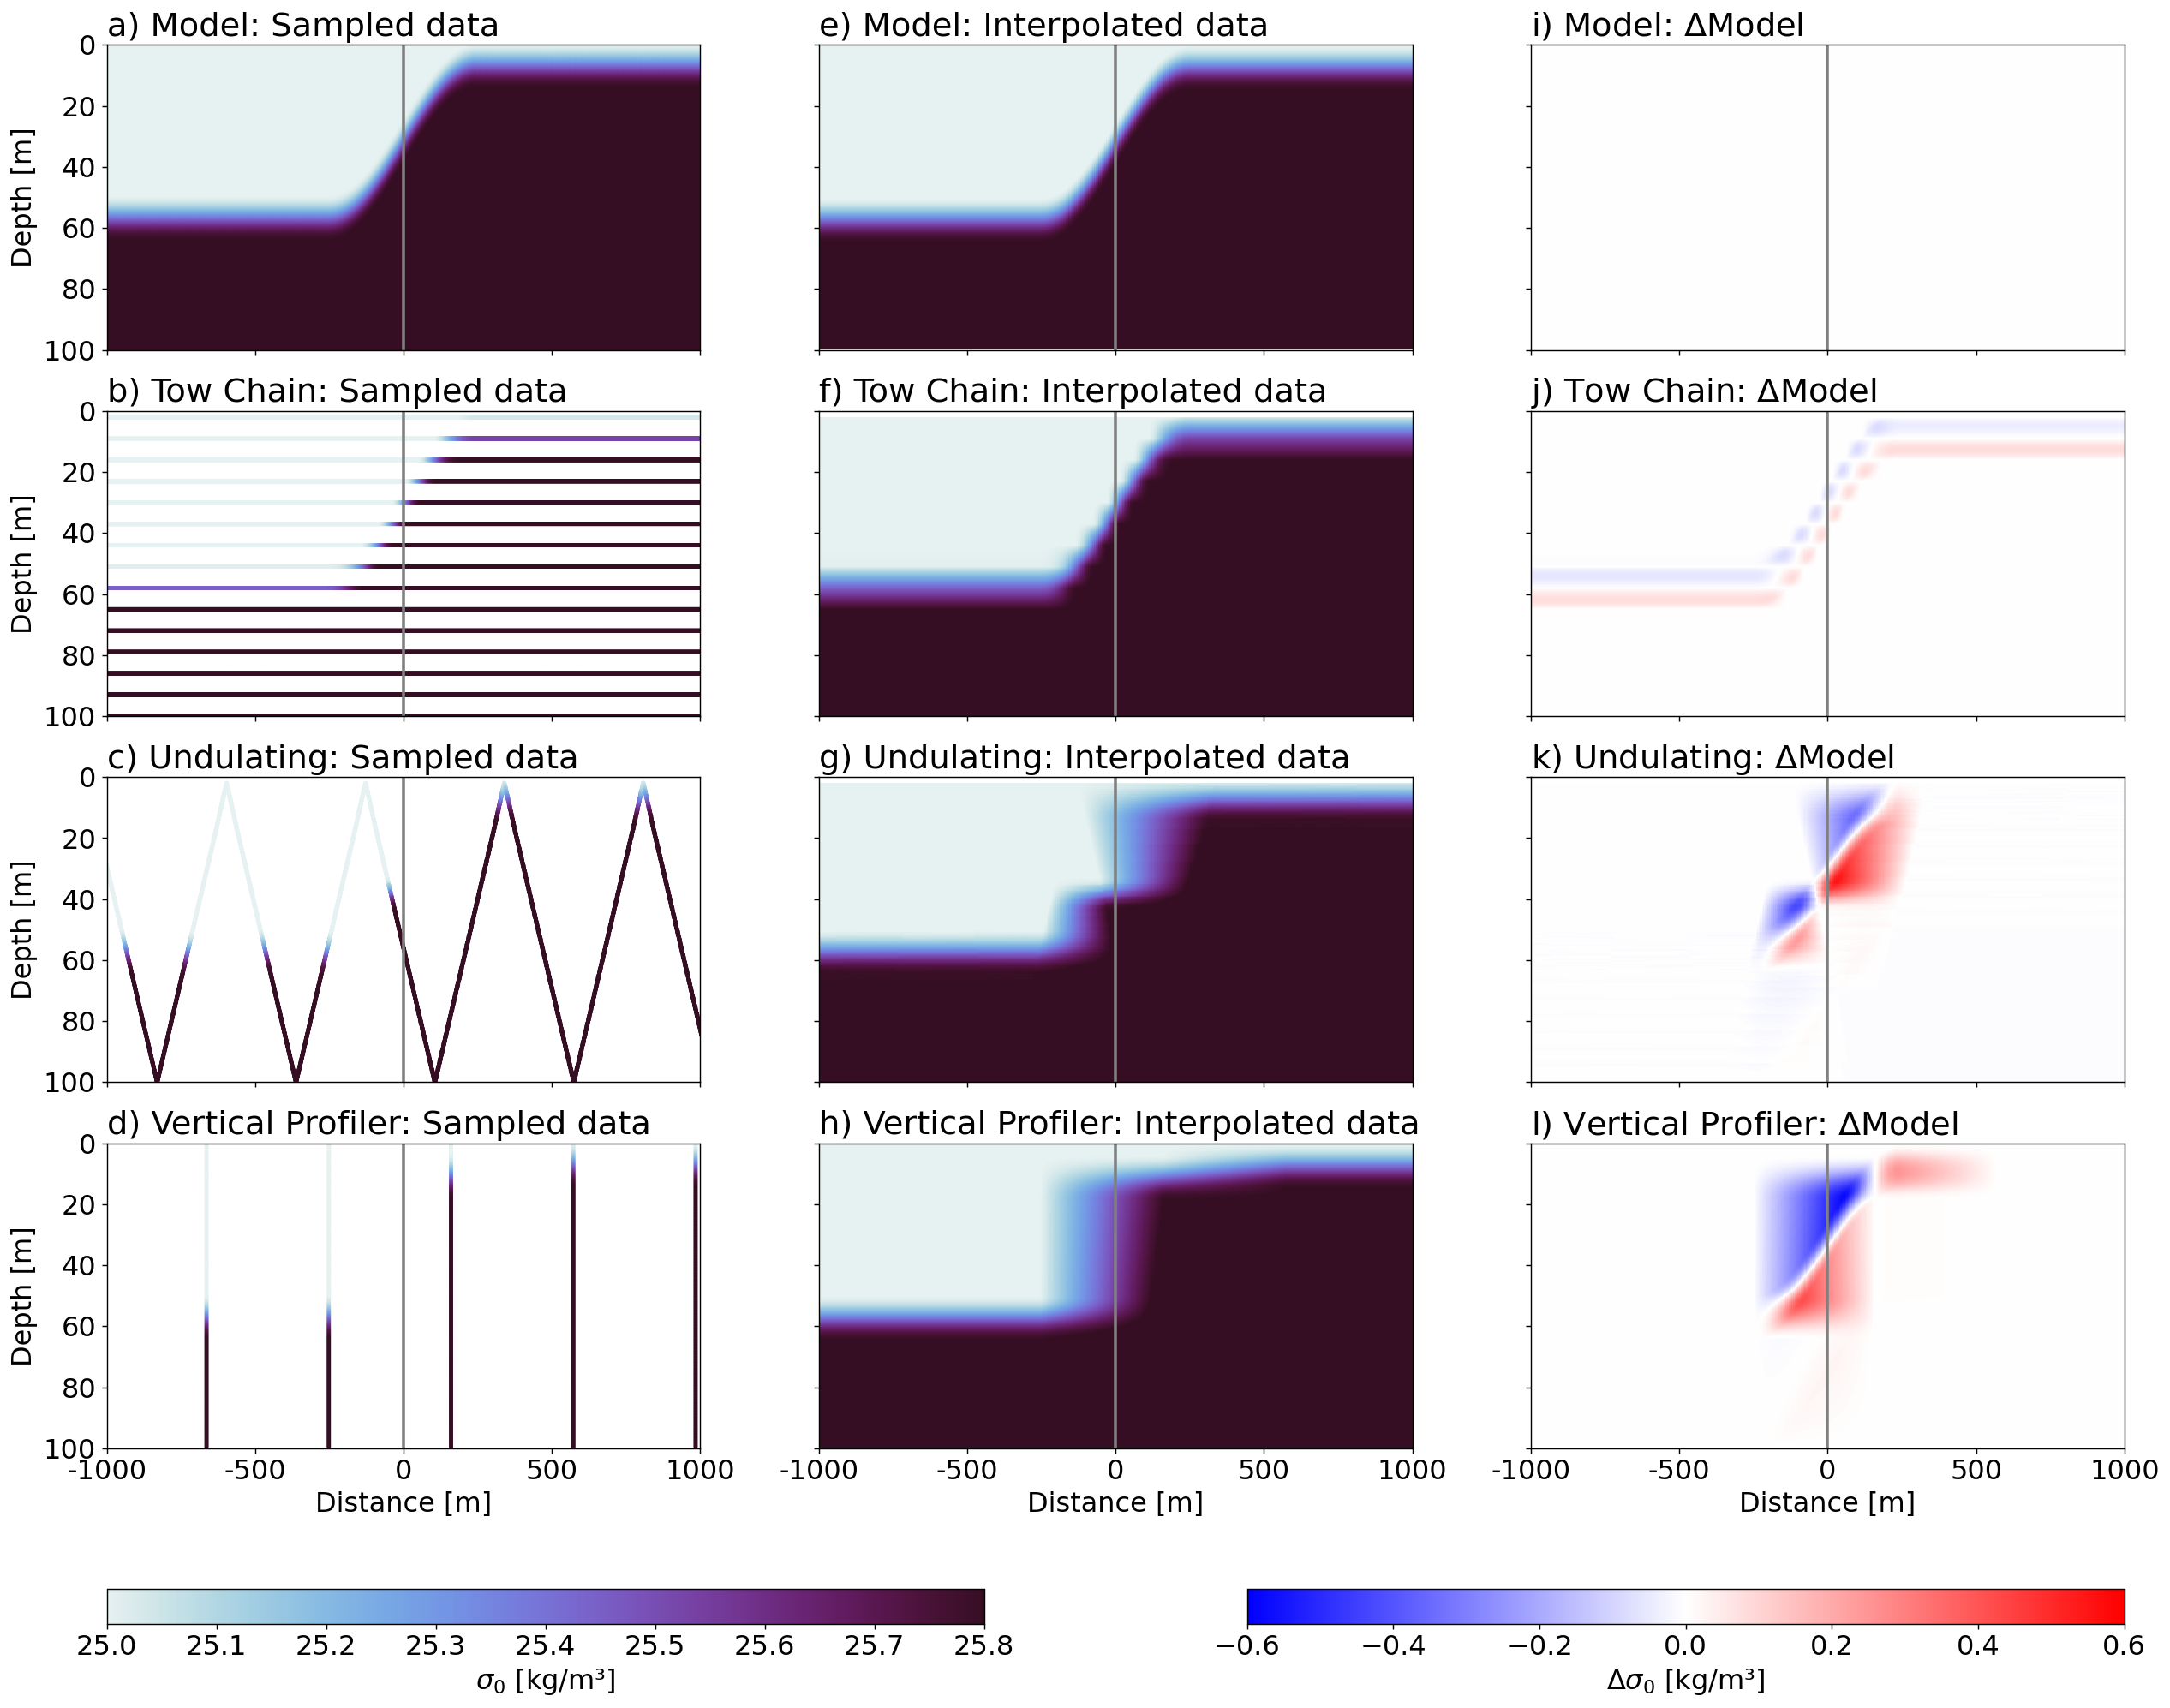

TIA stddev overall: 0.000338
SF stddev overall: 0.002048
UCTD stddev overall: 0.003238


In [6]:
# the maain product of this notebook is the 3 by 4 plot generated in this cell
source = ["Model", "Tow Chain", "Undulating", "Vertical Profiler"]
scatsize=3

fc, ac = plt.subplots(
    4, 3, sharex=True, sharey=True, figsize=(20,16), dpi=128, num="Comparison",
    facecolor='w'
    )

# the minimal values are still labelled with 't' because it was temprature at the beginning
# not density
tmin = model.min_temp
tmax = model.max_temp

# defining some limts for the later axes
ylim = (0, model.MAX_DEPTH)
if not XLIM:
    xlim = (0, model.DOMAIN_LENGTH)
else:
    xlim = XLIM

# compute the deviation arrays and determine the maxima and minima
delta_tia = model.temp_array.T - tia.temp_array
print(f"Maximum delta for TIA: {numpy.nanmax(numpy.fabs(delta_tia)):.4f}")
delta_undu = model.temp_array.T - undu.temp_array
print(f"Maximum delta for Undu: {numpy.nanmax(numpy.fabs(delta_undu)):.4f}")
delta_uctd = model.temp_array.T - uctd.temp_array
print(f"Maximum delta for UCTD: {numpy.nanmax(numpy.fabs(delta_uctd)):.4f}")

# the overall extreme value is needed for scaling the cbar later
err_max = numpy.nanmax(numpy.concatenate([delta_tia.flatten(), delta_uctd.flatten(), delta_undu.flatten()]))
err_min = numpy.nanmin(numpy.concatenate([delta_tia.flatten(), delta_uctd.flatten(), delta_undu.flatten()]))
print(f"Max error: {err_max:.3f}, min error: {err_min:.3f}")
if err_max > abs(err_min):
    err_min = -err_max
else:
    err_max = -err_min
err_max = round(err_max, 1)
err_min = round(err_min, 1)

# lets starts plotting with the
# model data
xx, yy = numpy.meshgrid(model.distances, model.z)
mod_scat = ac[0,0].scatter(xx.flatten(), yy.flatten(), c=model.temp_array.T.flatten(), cmap=CMAP, vmin=tmin, vmax=tmax, s=scatsize)
ac[0,1].pcolormesh(model.distances, model.z, model.temp_array.T, cmap=CMAP, vmin=tmin, vmax=tmax, shading="auto")
err = ac[0,2].pcolormesh(model.distances, model.z, model.temp_array.T - model.temp_array.T, cmap=CMAP_DIFF, vmin=err_min, vmax=err_max, shading="auto")
# tia data
for i in range(tia.nz):
    ac[1,0].scatter(tia.x_samples, numpy.ones_like(tia.x_samples) * tia.SENSOR_DEPTHS[i], c=tia.t_samples[i], cmap=CMAP, vmin=tmin, vmax=tmax, s=scatsize)
ac[1,1].pcolormesh(tia.model.distances, tia.model.z, tia.temp_array, cmap=CMAP, vmin=tmin, vmax=tmax, shading="auto")
ac[1,2].pcolormesh(tia.model.distances, tia.model.z, delta_tia, cmap=CMAP_DIFF, vmin=err_min, vmax=err_max, shading="auto")
# scanfish data
ac[2,0].scatter(undu.x_samples, undu.z_samples, c=undu.t_samples, cmap=CMAP, vmin=tmin, vmax=tmax, s=scatsize)
ac[2,1].pcolormesh(undu.model.distances, undu.model.z, undu.temp_array, cmap=CMAP, vmin=tmin, vmax=tmax, shading="auto")
ac[2,2].pcolormesh(undu.model.distances, undu.model.z, delta_undu, cmap=CMAP_DIFF, vmin=err_min, vmax=err_max, shading="auto")
# uctd data
for i in range(uctd.nx):
    ac[3,0].scatter(numpy.ones_like(uctd.z_samples) * uctd.x_samples[i], uctd.z_samples, c=uctd.t_samples[i], cmap=CMAP, vmin=tmin, vmax=tmax, s=scatsize)
ac[3,1].pcolormesh(uctd.model.distances, uctd.model.z, uctd.temp_array, cmap=CMAP, vmin=tmin, vmax=tmax, shading="auto")
ac[3,2].pcolormesh(uctd.model.distances, uctd.model.z, delta_uctd, cmap=CMAP_DIFF, vmin=err_min, vmax=err_max, shading="auto")

# tweak the plots by ...
# ... naming the subplots and apply axis manipulations
c = ord('a')
for i in range(4):
    ac[i,0].plot([FEATURE_CENTER, FEATURE_CENTER], [0, 100], lw=2, c='gray')
    ac[i,1].plot([FEATURE_CENTER, FEATURE_CENTER], [0, 100], lw=2, c='gray')
    ac[i,2].plot([FEATURE_CENTER, FEATURE_CENTER], [0, 100], lw=2, c='gray')
    ac[i, 0].set_ylim(ylim)
    ac[i, 0].set_xlim(xlim)
    ac[i, 0].set_ylabel("Depth [m]")
    ac[i, 0].set_title(chr(c) + ") " + source[i] + ": Sampled data", loc="left")
    c += 4
    ac[i, 1].set_title(chr(c) + ") " + source[i] + ": Interpolated data", loc="left")
    c += 4
    ac[i, 2].set_title(chr(c) + ") " + source[i] + r": $\Delta$" + source[0], loc="left")
    c -= 7
ac[0,0].invert_yaxis()
# ... rescaling the ticks on the x-axis to center around the feature
for i in range(3):
    ac[3,i].set_xlabel("Distance [m]")
    if xlim:
        current_ticks = ac[3,i].get_xticks()
        ac[3,i].set_xticks(current_ticks, labels=(current_ticks - model.FEATURE_CENTER).astype('i4'))
# ... adjusting the subplots parameters
fc.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.15)
# ... add horizontal colorbars at the bottom
cbar_val_ax = fc.add_axes([0.05, 0.05, 0.4, 0.02])
cbar_val = fc.colorbar(mod_scat, cax=cbar_val_ax, orientation="horizontal")
cbar_val.set_label(r"$\sigma_0$ [kg/m³]", loc="center")
cbar_err_ax = fc.add_axes([0.57, 0.05, 0.4, 0.02])
cbar_err = fc.colorbar(err, cax=cbar_err_ax, orientation="horizontal")
cbar_err.set_label(r"$\Delta\sigma_0$ [kg/m³]", loc="center")

# show and save
plt.show()
fc.savefig(f"{os.path.expanduser('~')}/devl/tc2013/Output/comparison.png")

# compute some statistics
print(f"TIA stddev overall: {numpy.nanvar(tia.model.temp_array.T - tia.temp_array):4f}")
print(f"SF stddev overall: {numpy.nanvar(undu.model.temp_array.T - undu.temp_array):4f}")
print(f"UCTD stddev overall: {numpy.nanvar(uctd.model.temp_array.T - uctd.temp_array):4f}")

In [7]:
# verify that all model data arrays are the same
print((undu.model.temp_array == tia.model.temp_array).all())
print((undu.model.temp_array == uctd.model.temp_array).all())

True
True
